In [1]:
!pip3 install scikit-learn
!pip3 install --upgrade ../.

Processing /app/alphafold
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Created wheel for alphafold: filename=alphafold-2.0.0-py3-none-any.whl size=167358 sha256=f8e65f45088319fb98ac818a1c0b772ace020c2aab5d246747aed6b3b99f7b2a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ze_7vqos/wheels/24/78/39/1d9adc7578a3110de260b58b488a10309326e694fcdf4c2b43
Successfully built alphafold
  Attempting uninstall: alphafold
    Found existing installation: alphafold 2.0.0
    Uninstalling alphafold-2.0.0:
      Successfully uninstalled alphafold-2.0.0


In [2]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import jax
import jax.numpy as jnp
import haiku as hk

import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from urllib import request
from concurrent import futures
import json
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
#import py3Dmol

from functools import partial
import math
import sklearn
from sklearn.decomposition import PCA

import alphafold

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

from enum import Enum

In [3]:
## alphafold-inspect

class MODEL_NAMES(Enum):
    model_1 = 'model_1'
    model_2 = 'model_2'
    model_3 = 'model_3'
    model_4 = 'model_4'
    model_5 = 'model_5'
    model_1_ptm = 'model_1_ptm'
    model_2_ptm = 'model_2_ptm'
    model_3_ptm = 'model_3_ptm'
    model_4_ptm = 'model_4_ptm'
    model_5_ptm = 'model_5_ptm'
    
    
def load_model(folder, model_name):
    model_name = MODEL_NAMES[model_name].value
    from alphafold.model import config
    from alphafold.model import data
    config = config.model_config(model_name)
    params = data.get_model_haiku_params(model_name, folder)
    return config, params


class _LayerWrapper:
    layer_name = "layer/"
    param_basename = 'alphafold/'
    param_keys = []
    pca_param_key = 0
    base_model = None
    
    def __init__(self, config, params=None, batch_shape=(1,), rng_key=0):
        self.config = config
        self.batch_shape = tuple(batch_shape)
        self.rng_key = jax.random.PRNGKey(rng_key)
        
        self.param_basename += self.layer_name
        self.param_names = [self.param_basename + k for k in self.param_keys]
        self.layer_param_names = [self.layer_name + k for k in self.param_keys]
        
        self.params = self.init_params()
        if params is not None:
            self.load_params(params)
            
        self.pca = PCA().fit(self.params[self.layer_param_names[self.pca_param_key]]["weights"].T)
        self.components = jax.device_put(self.pca.components_)
        
    @property
    def from_pca(self):
        @jax.jit
        def _from_pca(x):
            n_components = x.shape[-1]
            return jnp.matmul(x, self.components[:n_components])
        return _from_pca
    
    @property
    def to_pca(self, n_components=3):
        @jax.jit
        def _to_pca(x):
            return jnp.matmul(x, self.components[:n_components].T)
        return _to_pca
      
    @property
    def random_key(self):
        return jax.random.split(self.rng_key)[1]
        
    @property
    def init_shape(self):
        return (0,)
        
    def init_params(self):
        init_tensor = jnp.zeros(self.init_shape)
        layer_params = hk.data_structures.to_mutable_dict(self.forward_init(self.random_key, init_tensor))
        return layer_params
    
    def load_params(self, params):
        for b, p in zip(self.layer_param_names, self.param_names):
            pdict = {}
            for k, v in params[p].items():
                if getattr(self, 'layer_id', False):
                    v = v[self.layer_id]
                pdict[k] = v
            self.params[b] = pdict
    
    @property
    def local_config(self):
        return self.config
    
    @property
    def global_config(self):
        return self.config.model.global_config
    
    @property
    def model(self):
        name = self.layer_name.replace('/', '')
        return self.base_model(self.local_config, self.global_config, name=name)

    @property
    def _forward(self):
        def _forward(x):
            return self.model(x)
        return _forward
    
    @property
    def forward_init(self):
        return hk.transform(self._forward).init
    
    @property
    def forward_apply(self):
        apply = hk.transform(self._forward).apply
        return partial(apply, self.params, self.random_key)
    
    @property
    def forward_residual(self):
        @jax.jit
        def _forward_residual(x):
            return x + self.forward_apply(x)
        return _forward_residual
    
    @property
    def jacobian(self):
        return jax.jacfwd(self.forward_residual)
    
class Linear(hk.Module):
    def __init__(self,
               num_output: int,
               initializer: str = 'linear',
               use_bias: bool = True,
               bias_init: float = 0.,
               name: str = 'linear'):
        super().__init__(name=name)
        self.num_output = num_output
        self.initializer = initializer
        self.use_bias = use_bias
        self.bias_init = bias_init

    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        n_channels = int(inputs.shape[-1])

        weight_shape = [n_channels, self.num_output]
        if self.initializer == 'linear':
            weight_init = hk.initializers.VarianceScaling(mode='fan_in', scale=1.)
        elif self.initializer == 'relu':
            weight_init = hk.initializers.VarianceScaling(mode='fan_in', scale=2.)
        elif self.initializer == 'zeros':
            weight_init = hk.initializers.Constant(0.0)

        weights = hk.get_parameter('weights', weight_shape, inputs.dtype,
                                   weight_init)

        output = jnp.einsum('...c,cd->...d', inputs, weights)
        # this is equivalent to einsum('...c,cd->...d', inputs, weights)
        # but turns out to be slightly faster
        #inputs = jnp.swapaxes(inputs, -1, -2)
        #output = jnp.einsum('...cb,cd->...db', inputs, weights)
        #output = jnp.swapaxes(output, -1, -2)

        if self.use_bias:
            bias = hk.get_parameter('bias', [self.num_output], inputs.dtype,
                                  hk.initializers.Constant(self.bias_init))
            output += bias

        return output
    
class TransitionRunner(hk.Module):
    def __init__(self, config, global_config, name='transition_block'):
        super().__init__(name=name)
        self.config = config
        self.global_config = global_config

    def __call__(self, act):
        nc = act.shape[-1]
        num_intermediate = int(nc * self.config.num_intermediate_factor)

        return hk.Sequential([
            hk.LayerNorm(
                axis=[-1],
                create_scale=True,
                create_offset=True,
                name='input_layer_norm'),
            Linear(
                num_intermediate,
                initializer='relu',
                name='transition1'),
            jax.nn.relu,
            Linear(
                nc,
                initializer=alphafold.model.utils.final_init(self.global_config),
                name='transition2')
        ])(act)
    
class PairTransition(_LayerWrapper):
    layer_name = "pair_transition/"
    param_basename = "alphafold/alphafold_iteration/evoformer/evoformer_iteration/"
    param_keys = ['input_layer_norm', 'transition1', 'transition2']
    pca_param_key = 1
    base_model = TransitionRunner
    
    def __init__(self, layer_id, *args, **kwargs):
        self.layer_id = layer_id
        super(PairTransition, self).__init__(*args, **kwargs)
        
    @property
    def init_shape(self):
        c = self.config.model.embeddings_and_evoformer.pair_channel
        return self.batch_shape + (c,)
        
    @property
    def local_config(self):
        return self.config.model.embeddings_and_evoformer.evoformer.pair_transition

In [4]:
params_folder = '../alphafold/data'
model_name = 'model_2'


config, params = load_model(params_folder, model_name)
layer = PairTransition(34, config, params)

In [5]:
def loop(f, n):
    @jax.jit
    def step(i, x):
        return f(x)
    return partial(jax.lax.fori_loop, 1, n, step)

def loop_collect(forward_fn, out_fn, n, unroll=1):
    @jax.jit
    def step(x, _):
        y = forward_fn(x)
        return y, out_fn(y)
    return partial(jax.lax.scan, step, xs=None, length=n, unroll=unroll)

#runge-katta
def integrate(f, step_size=1):
    @jax.jit
    def _integrate(x):
        k1 = step_size * f(x)
        k2 = step_size * f(x + k1/2.)
        k3 = step_size * f(x + k2/2.)
        k4 = step_size * f(x + k3)
        
        return x + 1./6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return _integrate

@jax.jit
def lstsq(x):
    zeros = jnp.zeros(x.shape[0])
    return jnp.linalg.lstsq(x, zeros)

@jax.jit
def svd(x):
    return jnp.linalg.svd(x, compute_uv=False)

@jax.jit
def logdet(x):
    #return jnp.linalg.det(x)
    sign, logdet = jnp.linalg.slogdet(x)
    return sign * logdet

@jax.jit
def trace(x):
    return jnp.trace(x, axis1=-2, axis2=-1)

def matrix_stats(f):
    @jax.jit
    def _stats(x):
        y = f(x)
        #svals = svd(y)
        eigvals, eigvecs = eig_cpu(y)
        #slogdet = logdet(y)
        #tr = trace(y)
        return {
            "jacobian_eigvals": eigvals,
            "jacobian_eigvecs": eigvecs,
            #"jacobian_svals": svals,
            #"jacobian_logdet": slogdet,
            #"jacobian_trace": tr,
        }
    return _stats

In [6]:
def from_spherical(angle_grid, r):
    return np.stack([
        r * np.cos(angle_grid[...,0]) * np.sin(angle_grid[...,1]),
        r * np.sin(angle_grid[...,0]) * np.sin(angle_grid[...,1]),
        r * np.cos(angle_grid[..., 1])
    ], axis=-1)

def to_spherical(xyz):
    return np.stack([
        np.atan2(xyz[...,1], xyz[...,0]),
        np.atan2(np.linalg.norm(xyz[...,:2], axis=-1), xyz[...,2]),
        np.linalg.norm(xyz, axis=-1)
    ], axis=-1)

def get_grid_ns(n: int = 300, dims: int = 2, sizes = (-1.0, 1.0)):
    if type(n) is int:
        n = [n] * dims
    if type(sizes[0]) in [float, int]:
        sizes = [sizes] * dims

    steps = [np.linspace(sizes[i][0], sizes[i][1], n[i]) for i in range(dims)]
    return np.stack(np.meshgrid(*steps), axis=-1)

In [23]:
step_size = 1
n_iters = 1
j_iters = 1000#layer.init_shape[-1] * 2 + 1
pre_iters = layer.init_shape[-1]
n_points = 2160
n_dims = 2
batch_size = 100

n_p = jax.device_count()
batch_size *= n_p

proj_fn = layer.from_pca

pre_fn = loop(layer.forward_residual, pre_iters)

forward_fn = layer.forward_residual
out_fn = jax.jacfwd(loop(layer.forward_residual, j_iters))
fn = loop_collect(forward_fn, out_fn, n_iters)

@jax.pmap
@jax.vmap
@jax.jit
def batch_fn(x):
    iter1 = pre_fn(proj_fn(x))
    return fn(iter1)[1]

In [24]:
def axis_hue(eigvals, eigvecs):
    softmax_eigvals = jax.nn.softmax(eigvals.real, axis=-1)
    axis_scores = (jnp.abs(eigvecs.real).argmax(axis=-1) * softmax_eigvals).sum(axis=-1)
    axis_scores /= eigvals.shape[-1] - (1 - 1e-5)
    return axis_scores

@jax.vmap
@jax.vmap
@jax.jit
def dimension(tensor):
    tensor = jnp.sort(tensor, axis=-1)
    mask = tensor >= 0
    count = mask.sum()
    num = jnp.sum(tensor, where=mask)
    denom = jnp.sum(jnp.abs(tensor), where=~mask)
    #denom = jnp.abs(tensor[count])
    #denom = jnp.abs(tensor[-1])
    return count + (num / denom)

In [25]:
# unfirom points on a sphere
grid = get_grid_ns(
    n=n_points, 
    dims=n_dims, 
    #sizes=[(-np.pi, np.pi), (-1, 1)]
    sizes=[(-np.pi * 0.5, -np.pi * 0.4), (-0.5, -0.4)]
)
#jax.ops.index_update(grid, jax.ops.index[...,1], jnp.arccos(grid[...,1]))
grid[...,1] = np.arccos(grid[...,1])
grid = from_spherical(grid, r=30.0)
points = grid.reshape(-1, grid.shape[-1])

#eigvals, eigvecs = [], []
hues, dims, maxdirs = [], [], []
for i in tqdm.notebook.tqdm(range(0, points.shape[0], batch_size)):
    subbatch = points[i:i+batch_size]
    subbatch = subbatch.reshape(n_p, subbatch.shape[0]//n_p, *subbatch.shape[1:])
    subout = batch_fn(subbatch)
    subout = subout.reshape(subout.shape[0] * subout.shape[1], *subout.shape[2:])
    subvals, subvecs = np.linalg.eig(subout)
    subhues = axis_hue(subvals, subvecs)
    subdims = dimension(subvals.real)
    submaxdirs = subvals.real.argmax(axis=-1) / (subvals.shape[-1] - (1 - 1e-5))
    hues.append(subhues)
    dims.append(subdims)
    maxdirs.append(submaxdirs)
    #eigvals.append(subvals)
    #eigvecs.append(subvecs)
    
hues = jnp.concatenate(hues)
dims = jnp.concatenate(dims)
maxdirs = jnp.concatenate(maxdirs)
#eigvals = jnp.concatenate(eigvals)
#eigvecs = jnp.concatenate(eigvecs)
#print(eigvals.shape, eigvecs.shape)
print(hues.shape, dims.shape, maxdirs.shape)

outputs = jnp.transpose(jnp.stack([hues, dims, maxdirs], axis=-1).reshape(n_points, n_points, hues.shape[1], 3), (2, 0, 1, 3))
outputs = (outputs - outputs.min(axis=[0,1,2])) / (outputs.max(axis=[0,1,2]) - outputs.min(axis=[0,1,2]))
print(outputs.shape)

  0%|          | 0/23328 [00:00<?, ?it/s]

(4665600, 1) (4665600, 1) (4665600, 1)
(1, 2160, 2160, 3)


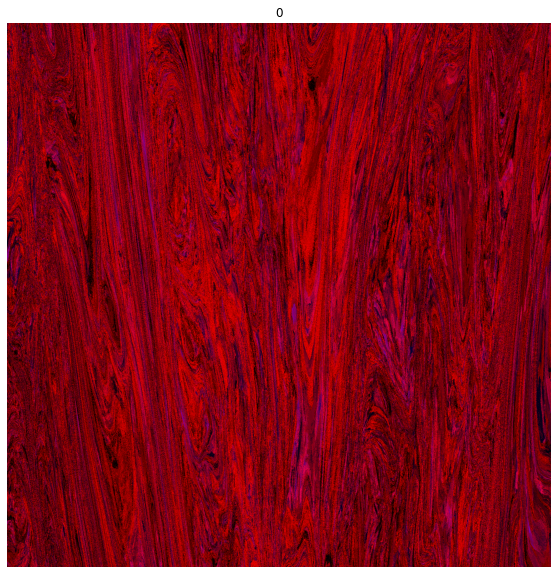

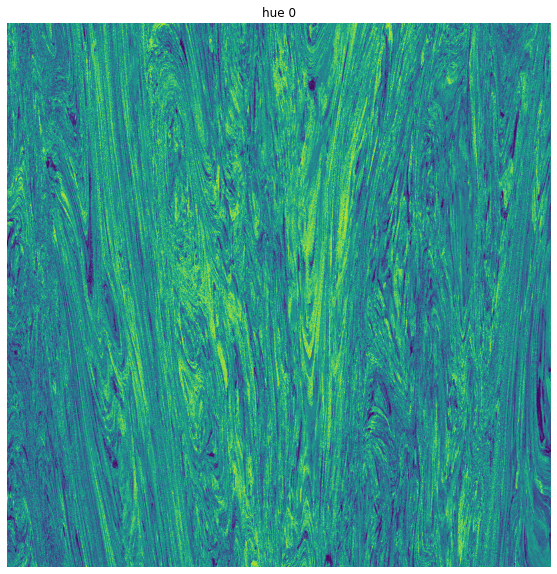

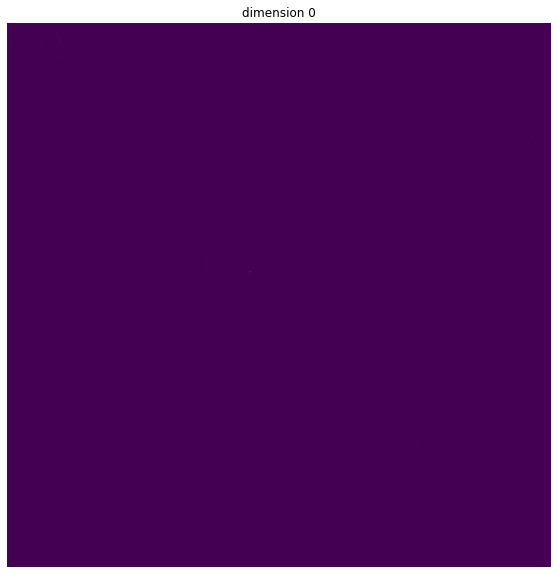

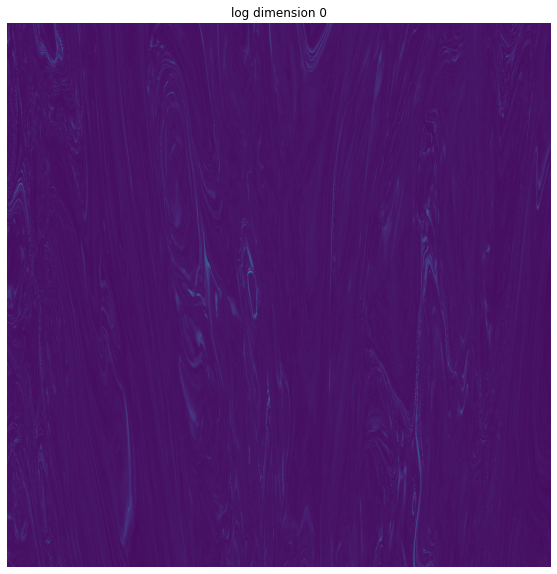

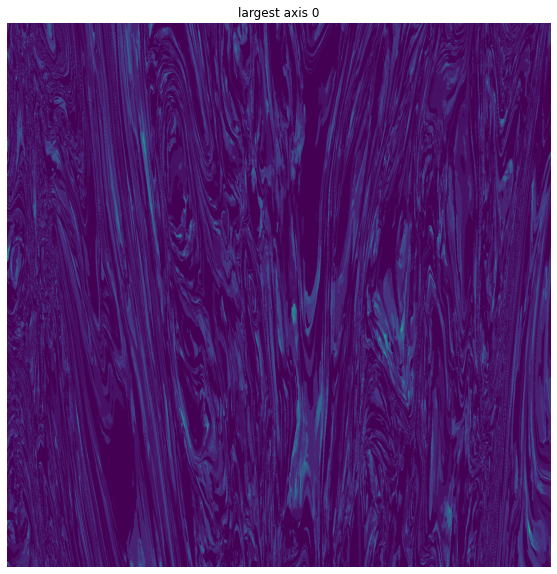

In [26]:
for i in range(outputs.shape[0]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(np.asarray(outputs[i]*256, dtype=np.uint8))
    plt.title(i)
    plt.axis('off')
    plt.show()
    
for i in range(outputs.shape[0]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(hues[:,i].reshape(n_points, n_points))
    plt.title(F"hue {i}")
    plt.axis('off')
    plt.show()
    
for i in range(outputs.shape[0]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(dims[:,i].reshape(n_points, n_points))
    plt.title(F"dimension {i}")
    plt.axis('off')
    plt.show()

for i in range(outputs.shape[0]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(jnp.log(dims[:,i].reshape(n_points, n_points)))
    plt.title(F"log dimension {i}")
    plt.axis('off')
    plt.show()
    
for i in range(outputs.shape[0]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(maxdirs[:,i].reshape(n_points, n_points))
    plt.title(F"largest axis {i}")
    plt.axis('off')
    plt.show()

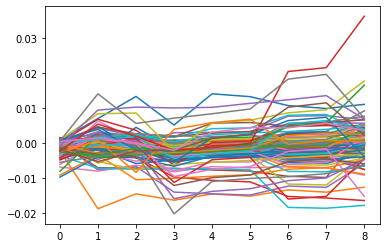

In [106]:
for i in range(1, 2):
    for j in range(128):
        a = out_dict["jacobian_svals"][i,:-1,j]
        b = out_dict["jacobian_svals"][i,1:,j]
        plt.plot(jnp.cumsum(b - a))
plt.show()

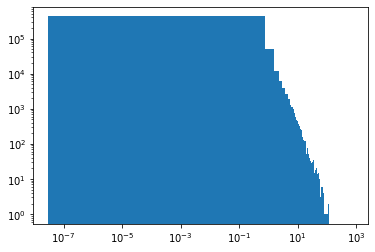

In [282]:
plt.hist(jnp.abs(eigvals.real).reshape(-1), bins=1000)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [266]:
@jax.vmap
@jax.vmap
@jax.jit
def dimension(tensor):
    tensor = jnp.sort(tensor, axis=-1)
    mask = tensor >= 0
    count = mask.sum()
    num = jnp.sum(tensor, where=mask)
    denom = jnp.sum(jnp.abs(tensor), where=~mask)
    #denom = jnp.abs(tensor[count])
    #denom = jnp.abs(tensor[-1])
    return count + (num / denom), denom, count

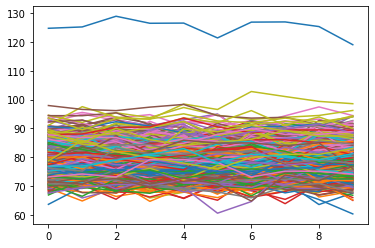

In [283]:
dim, ratio, count = dimension(eigvals.real)

for i in range(dim.shape[0]):
    plt.plot(dim[i])
plt.show()

In [285]:
dim = jnp.cumsum(dim, axis=-1)

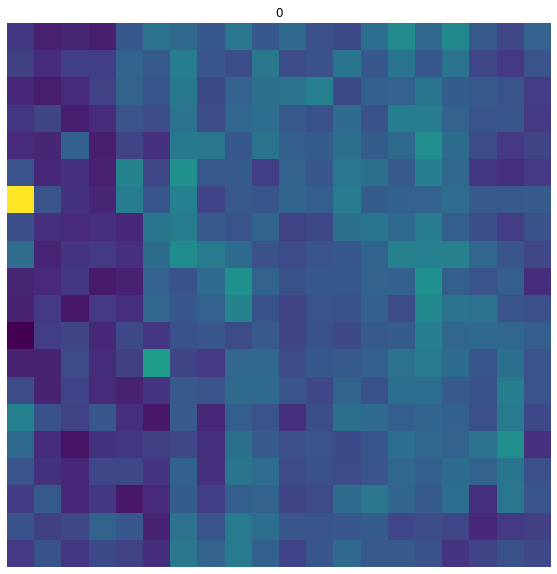

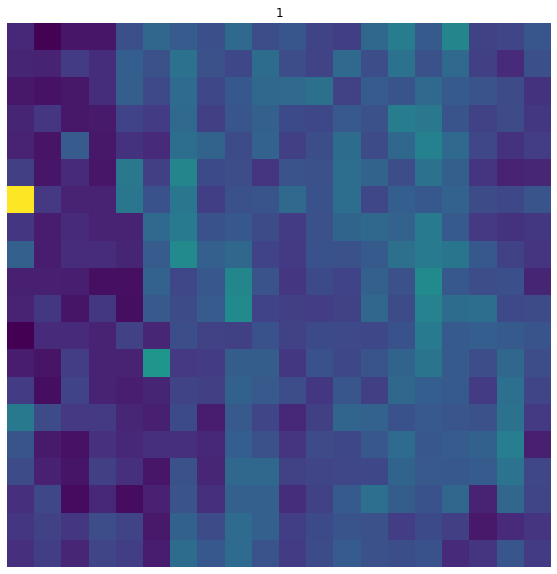

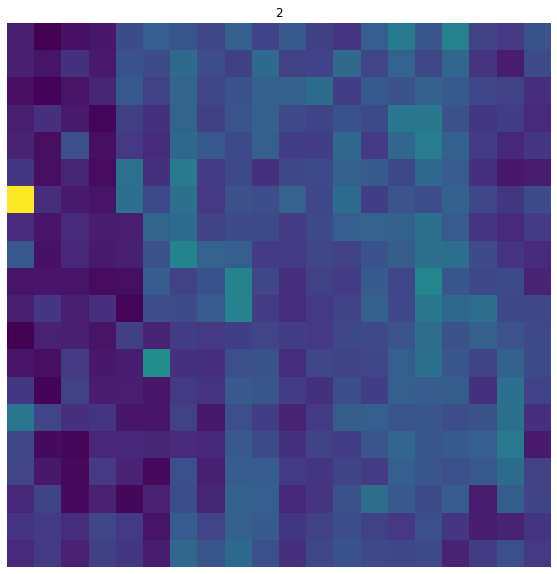

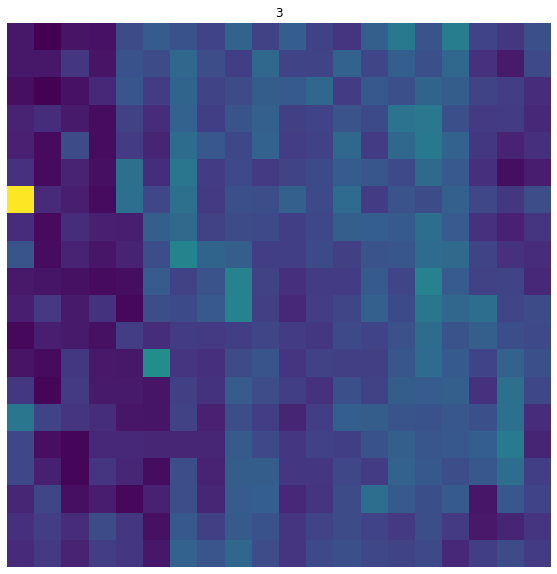

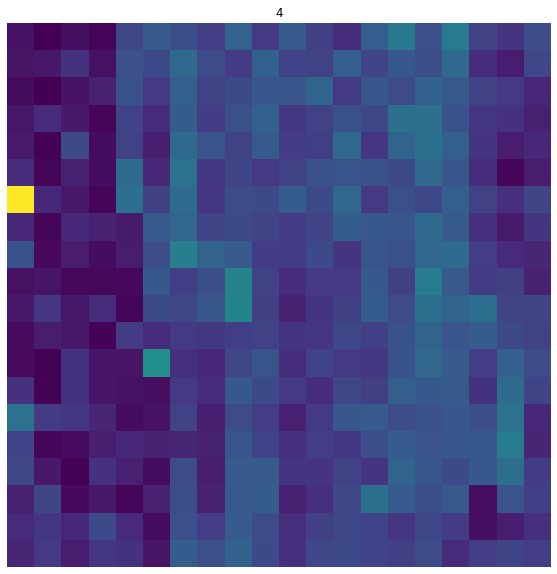

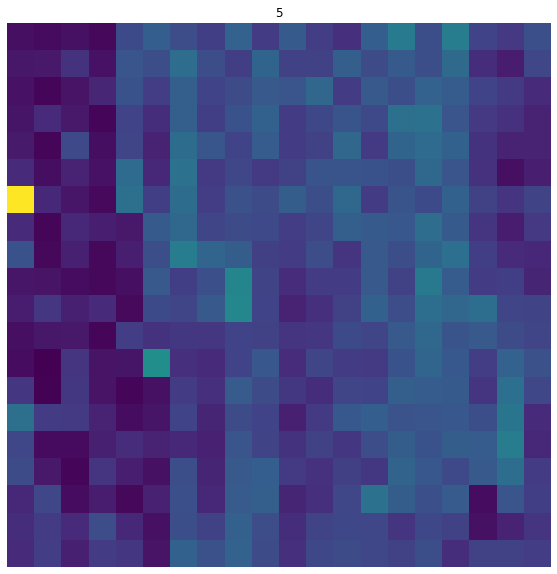

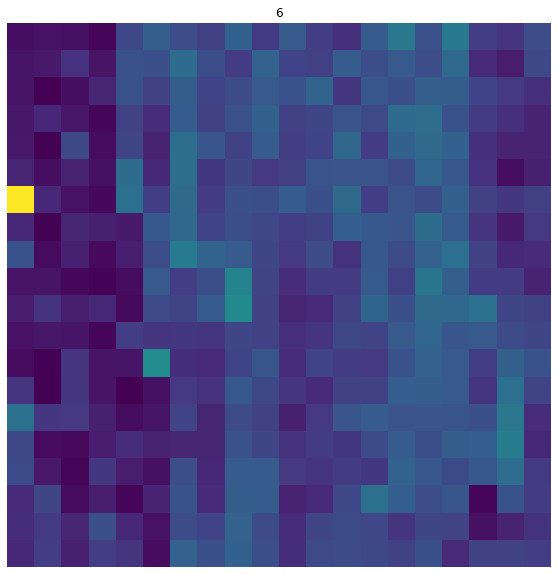

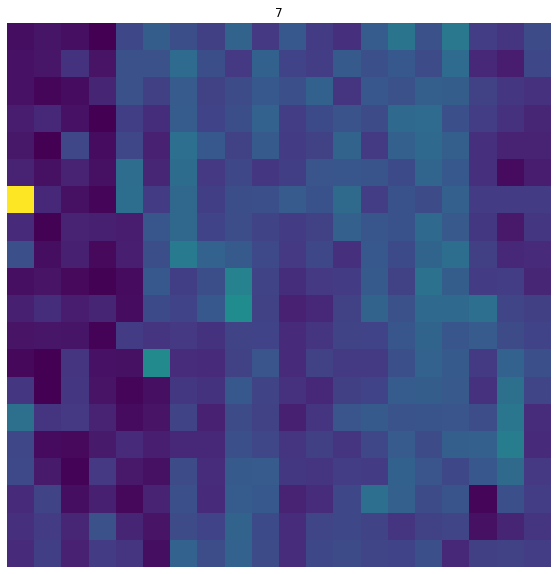

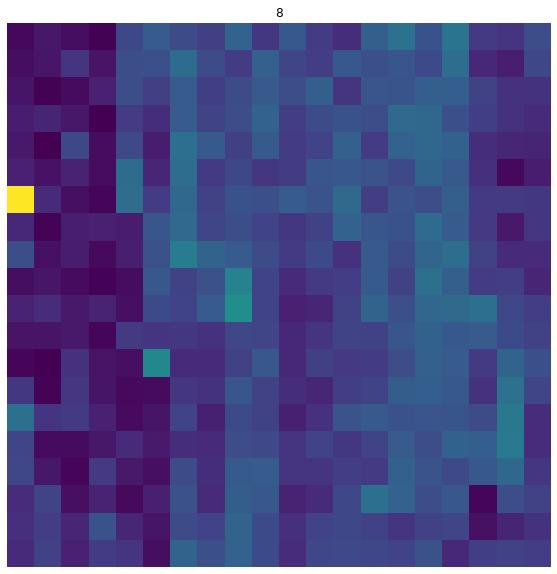

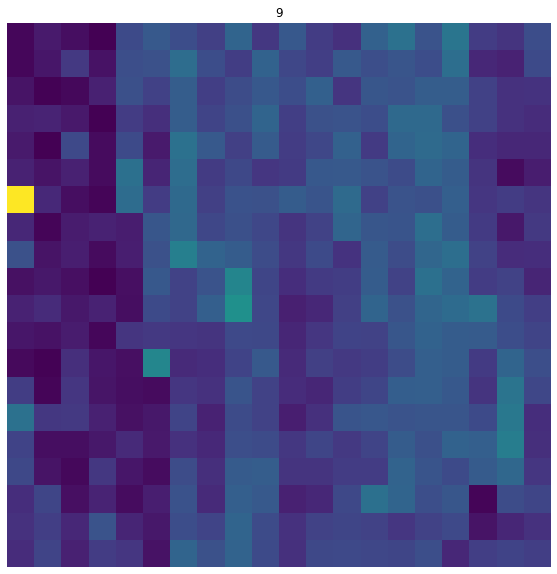

In [287]:
for i in range(dim.shape[-1]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(dim[:,i].reshape(n_points, n_points))
    plt.axis('off')
    plt.title(i)
    plt.show()

In [323]:
avg_axes = jnp.matmul(jax.nn.softmax(eigvecs.real, axis=-1), jnp.linspace(0, eigvecs.shape[-1], eigvecs.shape[-1]))
softmax_eigvals = jax.nn.softmax(eigvals.real, axis=-1)
weighted_hues = (avg_axes * softmax_eigvals).mean(axis=-1)
print(avg_axes.std(axis=-1))

[[0.3341068  0.36836928 0.34805065 ... 0.3197814  0.31028837 0.4228439 ]
 [0.2726872  0.38175488 0.2882149  ... 0.40040433 0.30691504 0.33504328]
 [0.4353514  0.32893622 0.34131745 ... 0.4216211  0.37195903 0.40210646]
 ...
 [0.26732555 0.31926662 0.3547318  ... 0.32072642 0.31716833 0.3438441 ]
 [0.42110986 0.31577256 0.36451584 ... 0.3295111  0.29340243 0.29483268]
 [0.3727342  0.2911292  0.3879316  ... 0.3627011  0.28677154 0.30224213]]


In [336]:
softmax_eigvals = jax.nn.softmax(eigvals.real, axis=-1)
axis_scores = (jnp.abs(eigvecs.real).argmax(axis=-1) * softmax_eigvals).sum(axis=-1)
axis_scores /= eigvals.shape[-1] - (1 - 1e-5)
axis_scores = jnp.asarray(axis_scores * 256, dtype=np.uint8)

DeviceArray(60.554478, dtype=float32)

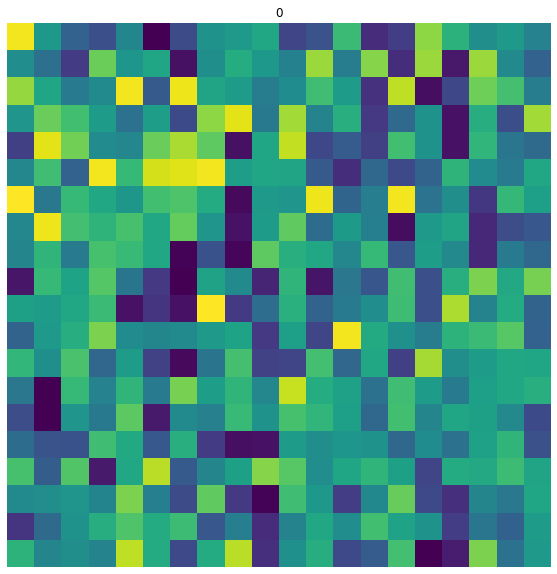

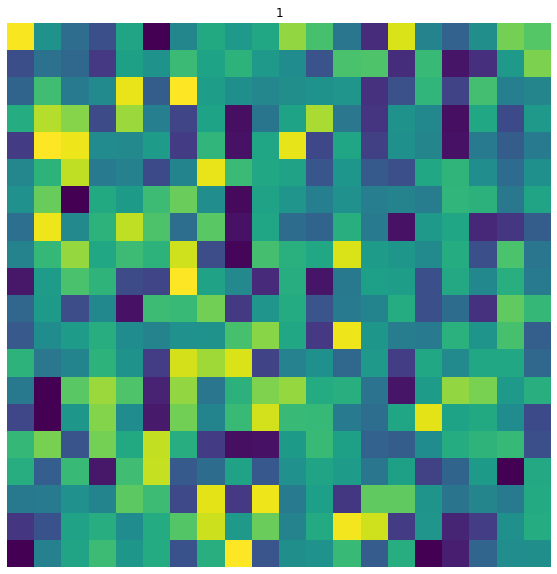

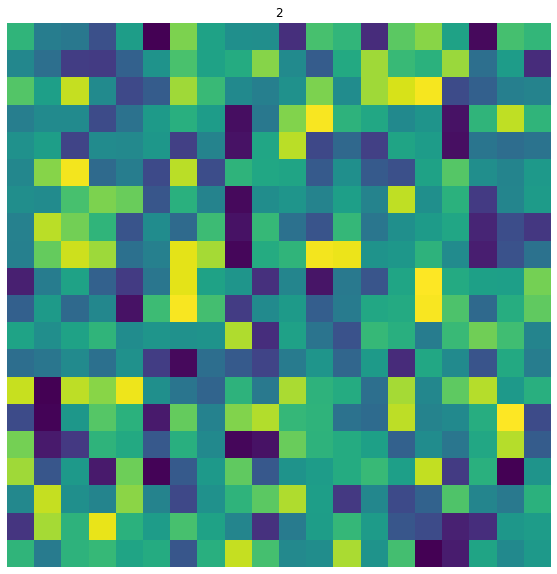

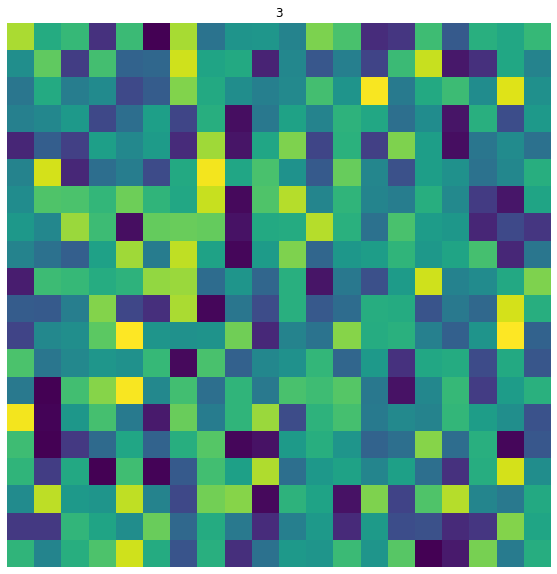

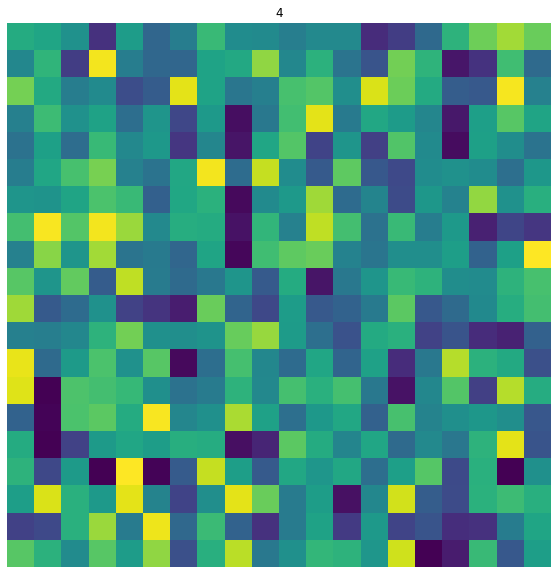

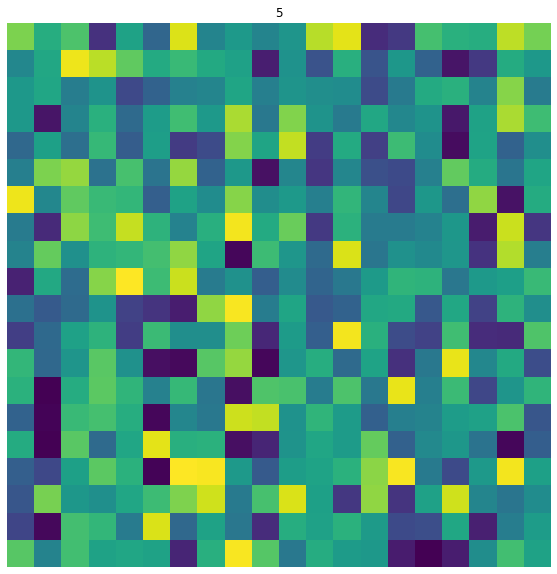

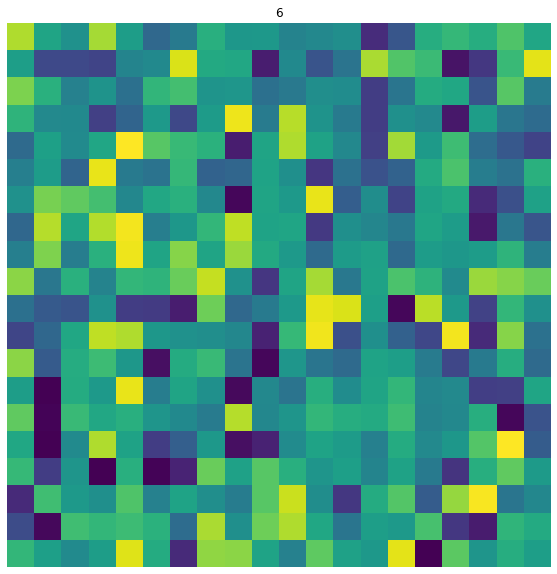

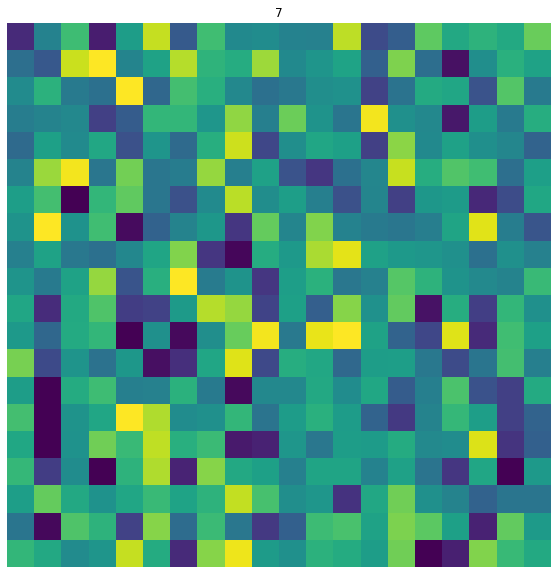

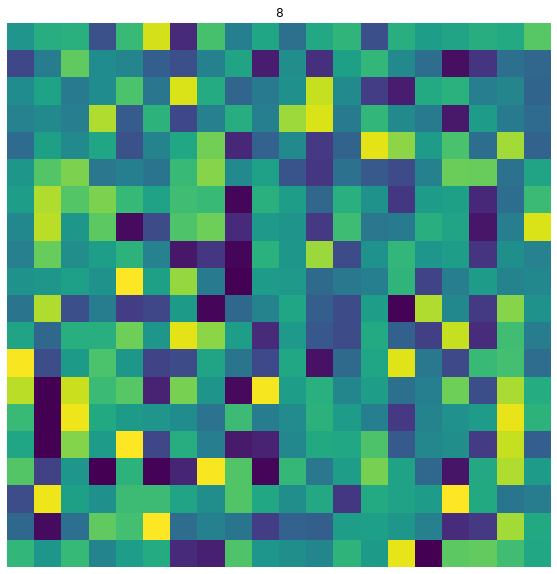

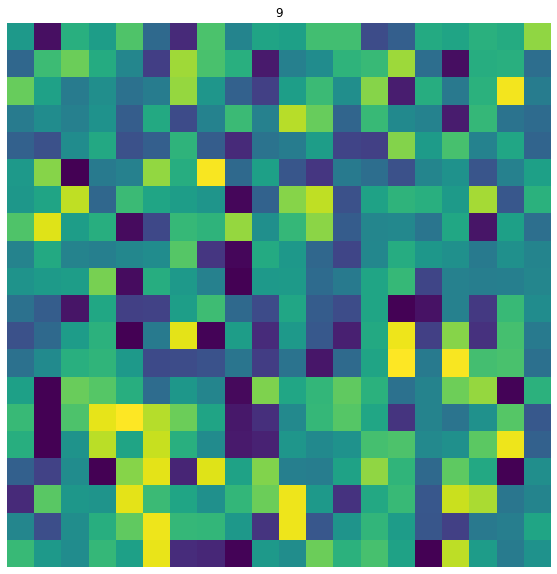

In [337]:
for i in range(dim.shape[-1]):
    plt.gcf().set_size_inches(10, 10)
    plt.imshow(axis_scores[:,i].reshape(n_points, n_points))
    plt.axis('off')
    plt.title(i)
    plt.show()

In [310]:

softmax_eigvals = jnp.repeat(softmax_eigvals[...,np.newaxis], softmax_eigvals.shape[-1], axis=-1)
scaled_eigvecs = eigvecs * softmax_eigvals
print(scaled_eigvecs.shape)

(400, 10, 128, 128)


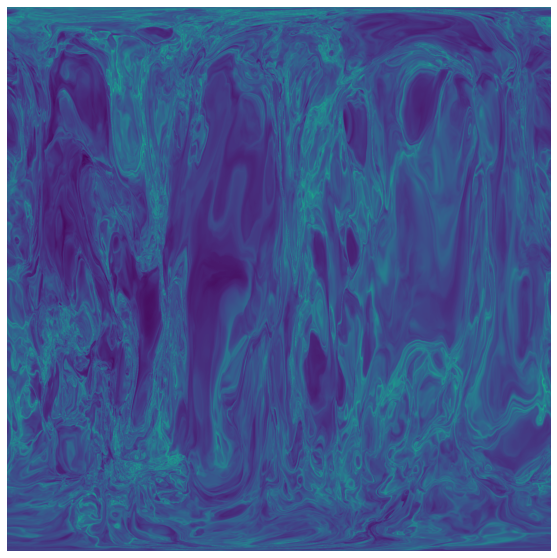

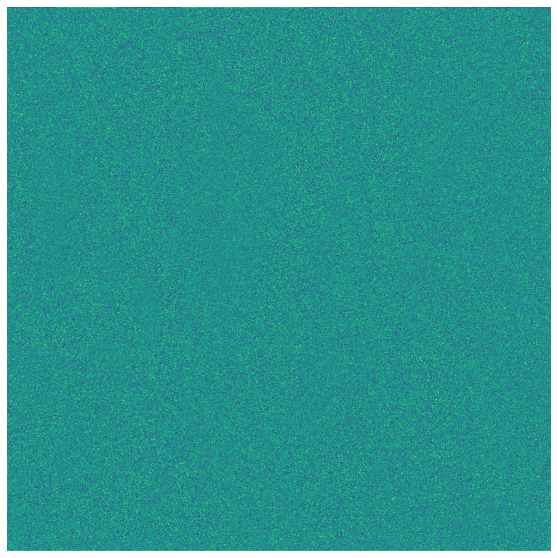

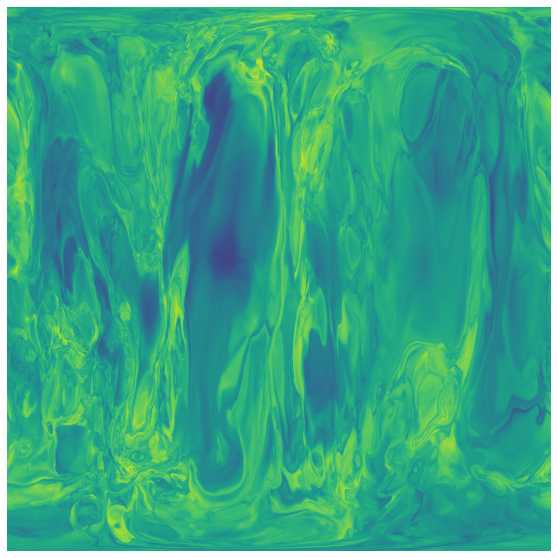

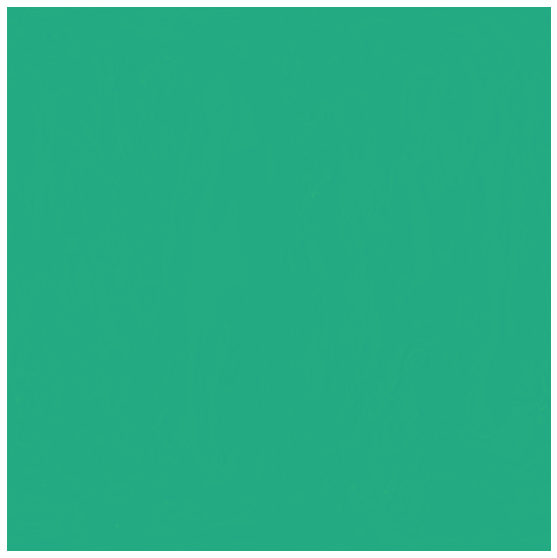

In [240]:
shape = [n_points]*n_dims
output = output.reshape(*shape, output.shape[-1])

plt.gcf().set_size_inches(10, 10)
plt.imshow(jnp.log(output[...,0]))
plt.axis('off')
plt.show()

plt.gcf().set_size_inches(10, 10)
plt.imshow(output[...,1])
plt.axis('off')
plt.show()

plt.gcf().set_size_inches(10, 10)
plt.imshow(jnp.abs(output[...,1]))
plt.axis('off')
plt.show()

plt.gcf().set_size_inches(10, 10)
plt.imshow(output[...,2])
plt.axis('off')
plt.show()

In [230]:
output.append(subout.reshape(subbatch.shape[0] * subbatch.shape[1], *points.shape[1:]))

In [ ]:
%%timeit

rand_input = jax.random.normal(layer.random_key, shape=(b, layer.init_shape[-1],))
output = jax.vmap(loop(layer.forward_residual, l))(rand_input)

In [ ]:
%%timeit

rand_input = jax.random.normal(layer.random_key, shape=(jax.device_count(), b // 2, layer.init_shape[-1]))
output = jax.pmap(jax.vmap(loop(layer.forward_residual, l)))(rand_input)

In [ ]:
%%timeit

rand_input = jax.random.normal(layer.random_key, shape=(jax.device_count(), b, layer.init_shape[-1]))
f = jax.jit(lambda x: jnp.linalg.norm(layer.forward_residual(x), axis=-1))
output = jax.pmap(jax.vmap(f))(rand_input)

In [ ]:
rand_input = jax.random.normal(layer.random_key, shape=(jax.device_count(), b, layer.init_shape[-1]))
f = jax.jit(lambda x: jnp.linalg.norm(layer.forward_residual(x), axis=-1))
output = jax.pmap(jax.vmap(f))(rand_input)

In [ ]:
output.shape

In [ ]:
rand_input = jax.random.normal(layer.random_key, shape=(b, layer.init_shape[-1],))
output = jax.vmap(layer.forward_residual)(rand_input)